In [303]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

In [320]:
# Load the Excel file
file_path = 'ie_data.xlsx'  # Replace with your file path
data = pd.read_excel(file_path, sheet_name='Data', skiprows=7)

data.columns

Index(['Date', 'P', 'D', 'E', 'CPI', 'Fraction', 'Rate GS10', 'Price',
       'Dividend', 'Price.1', 'Earnings', 'Earnings.1', 'CAPE', 'Unnamed: 13',
       'TR CAPE', 'Unnamed: 15', 'Yield', 'Returns', 'Returns.1',
       'Real Return', 'Real Return.1', 'Returns.2'],
      dtype='object')

In [321]:
data

,Date,P,D,E,CPI,Fraction,Rate GS10,Price,Dividend,Price.1,...,CAPE,Unnamed: 13,TR CAPE,Unnamed: 15,Yield,Returns,Returns.1,Real Return,Real Return.1,Returns.2
0,1871.01,4.44,0.260000,0.4,12.464061,1871.041667,5.32,112.456056,6.585265,1.124561e+02,...,NaN,NaN,NaN,NaN,NaN,1.004177,1.000000,0.130609,0.092504,0.038106
1,1871.02,4.5,0.260000,0.4,12.844641,1871.125000,5.323333,110.598690,6.390147,1.111312e+02,...,NaN,NaN,NaN,NaN,NaN,1.004180,0.974424,0.130858,0.094635,0.036224
2,1871.03,4.61,0.260000,0.4,13.034972,1871.208333,5.326667,111.647827,6.296841,1.127127e+02,...,NaN,NaN,NaN,NaN,NaN,1.004183,0.964209,0.130951,0.096186,0.034765
3,1871.04,4.74,0.260000,0.4,12.559226,1871.291667,5.33,119.144747,6.535366,1.208309e+02,...,NaN,NaN,NaN,NaN,NaN,1.004185,1.004919,0.122056,0.090972,0.031084
4,1871.05,4.86,0.260000,0.4,12.273812,1871.375000,5.333333,125.001800,6.687339,1.273360e+02,...,NaN,NaN,NaN,NaN,NaN,1.004188,1.032591,0.122638,0.089488,0.033150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,2024.11,5929.916,74.354836,NaN,315.493,2024.875000,4.36,5933.599960,74.401029,3.970269e+06,...,37.438763,NaN,40.304336,NaN,0.012500,1.001225,39.328482,NaN,NaN,NaN
1847,2024.12,6010.908571,74.832255,NaN,315.605,2024.958333,4.39,6012.508408,74.852172,4.027241e+06,...,37.895930,NaN,40.809220,NaN,0.012500,0.984603,39.362679,NaN,NaN,NaN
1848,2025.01,5979.5155,NaN,NaN,315.661,2025.041667,4.63,5980.045899,NaN,4.005498e+06,...,37.648511,NaN,40.513595,NaN,0.010778,1.011835,38.749723,NaN,NaN,NaN
1849,2025.02,6037.88,NaN,NaN,315.689,2025.125000,4.53,6037.880000,NaN,4.044235e+06,...,37.967247,NaN,40.827365,NaN,0.011118,NaN,39.204844,NaN,NaN,NaN


In [306]:
# Copy the original dataframe to avoid modifying the original data
inflation_data = data[['Date', 'CPI']].copy()

# Drop NaN values from Date column
inflation_data = inflation_data.dropna(subset=['Date'])

# Convert float date to DateTime format safely
inflation_data['Year'] = inflation_data['Date'].fillna(0).astype(int)  # Extract year (integer part)
inflation_data['Month'] = ((inflation_data['Date'] - inflation_data['Year']) * 100).round().astype(int)  # Extract month
inflation_data['Month'] = inflation_data['Month'].clip(1, 12)  # Ensure months are between 1 and 12
inflation_data['Date'] = pd.to_datetime(inflation_data[['Year', 'Month']].assign(day=1))  # Convert to DateTime
inflation_data.set_index('Date', inplace=True)

# Compute monthly inflation rate
inflation_data['Inflation'] = inflation_data['CPI'].pct_change()

# Define rolling window parameters
rolling_window = 30 * 12  # 30 years * 12 months
forecast_horizon = 10 * 12  # 10 years * 12 months

# Store results for the 10-year expected inflation series
expected_inflation = []

# Iterate over the rolling window
for start_idx in range(len(inflation_data) - rolling_window - forecast_horizon + 1):
    end_idx = start_idx + rolling_window  # Define the 30-year window
    forecast_start = end_idx
    forecast_end = forecast_start + forecast_horizon
    
    # Extract training data for AR(12) model
    train_data = inflation_data['Inflation'].iloc[start_idx:end_idx].dropna()
    
    # Fit AR(12) model if there's enough data
    if len(train_data) >= 12:
        model = AutoReg(train_data, lags=12, old_names=False).fit()
        forecast_values = model.predict(start=forecast_start, end=forecast_end - 1)
        
        # Compute the 10-year expected inflation (annualized)
        mean_monthly_inflation = np.mean(forecast_values)
        annualized_inflation = (1 + mean_monthly_inflation) ** 12 - 1
        
        # Store the result with the corresponding date
        expected_inflation.append((inflation_data.index[forecast_start], annualized_inflation))

# Convert results to DataFrame
expected_inflation_df = pd.DataFrame(expected_inflation, columns=['Date', '10-Year Expected Inflation'])
expected_inflation_df.set_index('Date', inplace=True)

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/sit

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with

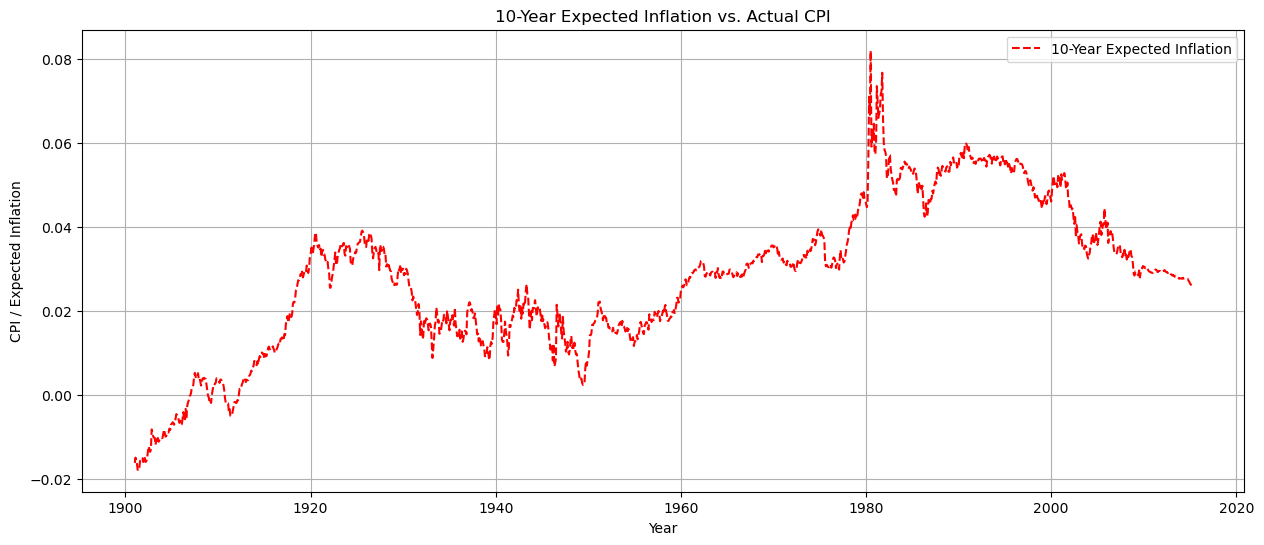

In [318]:
# Plot the 10-year expected inflation against actual CPI
plt.figure(figsize=(15, 6))

# Plot 10-year expected inflation
plt.plot(expected_inflation_df.index, expected_inflation_df['10-Year Expected Inflation'], 
         label="10-Year Expected Inflation", color='red', linestyle="dashed")

# Labels and title
plt.xlabel("Year")
plt.ylabel("CPI / Expected Inflation")
plt.title("10-Year Expected Inflation vs. Actual CPI")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [307]:
inflation_datata_data

,CPI,Year,Month,Inflation
Date,,,,
1871-01-01,12.464061,1871,1,NaN
1871-02-01,12.844641,1871,2,0.030534
1871-03-01,13.034972,1871,3,0.014818
1871-04-01,12.559226,1871,4,-0.036498
1871-05-01,12.273812,1871,5,-0.022726
...,...,...,...,...
2024-10-01,315.664,2024,10,0.001151
2024-11-01,315.493,2024,11,-0.000542
2024-12-01,315.605,2024,12,0.000355


In [ ]:
# Plot the 10-year expected inflation against actual CPI
plt.figure(figsize=(12, 6))

# Plot actual CPI
plt.plot(inflation_data.index, inflation_data['CPI'], label="Actual CPI", color='blue', alpha=0.6)

# Plot 10-year expected inflation
plt.plot(expected_inflation_df.index, expected_inflation_df['10-Year Expected Inflation'], 
         label="10-Year Expected Inflation", color='red', linestyle="dashed")

# Labels and title
plt.xlabel("Year")
plt.ylabel("CPI / Expected Inflation")
plt.title("10-Year Expected Inflation vs. Actual CPI")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [252]:
# Filter CAPE and Real Return columns
df = data[['Date', 'D', 'E', 'CPI', 'Dividend', 'CAPE', 'Rate GS10', 'TR CAPE', 'Real Return', 'Returns.2']].dropna()

# Separate Year and Month
df['Year'] = df['Date'].astype(int)

df['Month'] = ((df['Date'] - df['Year']) * 100).round().astype(int)

# Combine Year and Month into a datetime object
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df['dividend_payout'] = df['D']/df['E']

# Drop temporary Year and Month columns
df.drop(['Year', 'Month'], axis=1, inplace=True)

In [253]:
df

,Date,D,E,CPI,Dividend,CAPE,Rate GS10,TR CAPE,Real Return,Returns.2,dividend_payout
120,1881-01-01,0.265000,0.485800,9.41942,8.881395,18.473952,3.7,24.135057,0.045353,-0.011115,0.545492
121,1881-02-01,0.270000,0.481700,9.514585,8.958460,18.147258,3.693333,23.655503,0.046774,-0.009425,0.560515
122,1881-03-01,0.275000,0.477500,9.514585,9.124357,18.270119,3.686667,23.767713,0.042423,-0.012462,0.575916
123,1881-04-01,0.280000,0.473300,9.609669,9.198331,17.950108,3.68,23.308850,0.045971,-0.008665,0.591591
124,1881-05-01,0.285000,0.469200,9.514585,9.456152,18.869719,3.673333,24.456686,0.041157,-0.013628,0.607417
...,...,...,...,...,...,...,...,...,...,...,...
1725,2014-10-01,38.806667,104.743333,237.433,51.597031,25.162748,2.3,27.736946,0.103849,0.123984,0.370493
1726,2014-11-01,39.123333,103.526667,236.151,52.300460,26.606817,2.33,29.318655,0.099899,0.122165,0.377906
1727,2014-12-01,39.440000,102.310000,234.812,53.024437,26.794085,2.21,29.515333,0.100144,0.124106,0.385495
1728,2015-01-01,39.896667,101.290000,233.707,53.892005,26.492295,1.88,29.174671,0.100256,0.129241,0.393886


## CAPE Linear Model 

In [254]:
test_set

,Date,D,E,CPI,Dividend,CAPE,Rate GS10,TR CAPE,Real Return,Returns.2,dividend_payout,Earnings_Yield,Inflation,Real_Bond_Yield,Stock_Volatility,Bond_Volatility
1190,1970-03-01,3.170000,5.630000,38.2,26.197229,16.531691,7.07,19.058796,-0.016883,0.017452,0.563055,0.060490,NaN,NaN,NaN,NaN
1191,1970-04-01,3.173330,5.593330,38.5,26.020399,15.873068,7.39,18.311411,-0.015618,0.009395,0.567342,0.063000,NaN,NaN,NaN,NaN
1192,1970-05-01,3.176670,5.556670,38.6,25.980305,13.983836,7.91,16.149570,0.000329,0.014677,0.571686,0.071511,NaN,NaN,NaN,NaN
1193,1970-06-01,3.180000,5.520000,38.8,25.873480,13.799692,7.84,15.955063,0.006685,0.019440,0.576087,0.072465,NaN,NaN,NaN,NaN
1194,1970-07-01,3.183330,5.466670,39,25.767750,13.726500,7.46,15.888935,0.011574,0.029125,0.582316,0.072852,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,2014-10-01,38.806667,104.743333,237.433,51.597031,25.162748,2.3,27.736946,0.103849,0.123984,0.370493,0.039741,0.016643,2.283357,0.005473,0.174808
1726,2014-11-01,39.123333,103.526667,236.151,52.300460,26.606817,2.33,29.318655,0.099899,0.122165,0.377906,0.037584,0.013224,2.316776,0.005445,0.191414
1727,2014-12-01,39.440000,102.310000,234.812,53.024437,26.794085,2.21,29.515333,0.100144,0.124106,0.385495,0.037322,0.007565,2.202435,0.004953,0.194419
1728,2015-01-01,39.896667,101.290000,233.707,53.892005,26.492295,1.88,29.174671,0.100256,0.129241,0.393886,0.037747,-0.000893,1.880893,0.005233,0.243215


CAPE Model - MSE on Test Set: 0.003989465818759128
Alpha (Intercept): 0.16525324579964495
Beta (Slope): -0.0067190588585553344


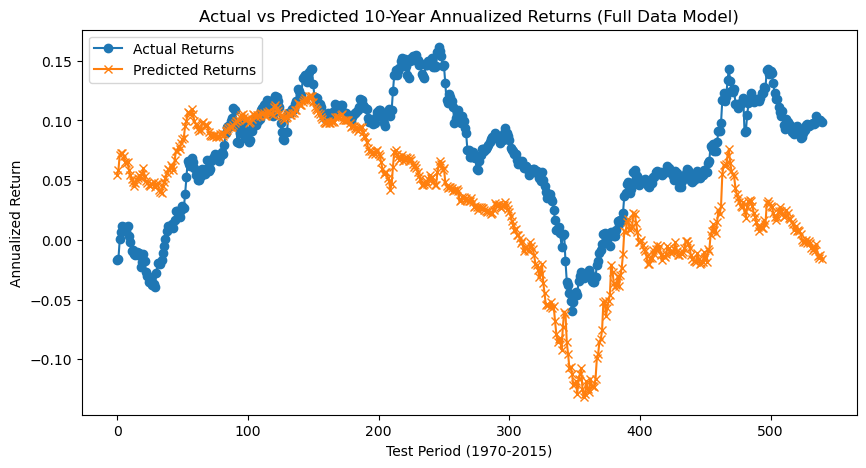

In [346]:
# Define test set (last 5 years)
test_set = df[df['Date'] >= '1970-03-01']

# Time Window 1: Full data from 1871 to 2010.02
train_set_full = df[df['Date'] < '1970-03-01']

# Separate features (CAPE) and target (Real Return)
X_train_full = train_set_full[['CAPE']]
y_train_full = train_set_full['Real Return']

X_test = test_set[['CAPE']]
y_test = test_set['Real Return']

# Train the linear regression model
model_full = LinearRegression()
model_full.fit(X_train_full, y_train_full)

# Predict on the test set
y_pred_full = model_full.predict(X_test)

# Calculate Mean Squared Error (MSE) for evaluation
mse_full = mean_squared_error(y_test, y_pred_full)

# Display results
print(f"CAPE Model - MSE on Test Set: {mse_full}")
print(f"Alpha (Intercept): {model_full.intercept_}")
print(f"Beta (Slope): {model_full.coef_[0]}")

# Plot Actual vs Predicted Returns
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Returns', marker='o')
plt.plot(y_pred_full, label='Predicted Returns', marker='x')
plt.title('Actual vs Predicted 10-Year Annualized Returns (Full Data Model)')
plt.xlabel('Test Period (1970-2015)')
plt.ylabel('Annualized Return')
plt.legend()
plt.show()

## TR CAPE

Full Data (1871-2010) Model - MSE on Test Set: 0.002950329837414206
Alpha (Intercept): 0.17242086930611966
Beta (Slope): -0.0057314876002447605


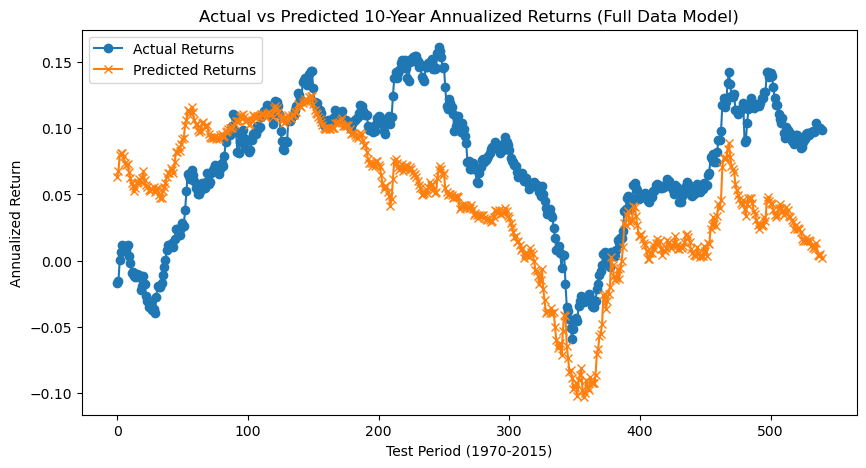

In [347]:
# Separate features (CAPE) and target (Real Return)
X_train_full = train_set_full[['TR CAPE']]
y_train_full = train_set_full['Real Return']

X_test = test_set[['TR CAPE']]
y_test = test_set['Real Return']

# Train the linear regression model
model_full = LinearRegression()
model_full.fit(X_train_full, y_train_full)

# Predict on the test set
y_pred_full = model_full.predict(X_test)

# Calculate Mean Squared Error (MSE) for evaluation
mse_full = mean_squared_error(y_test, y_pred_full)

# Display results
print(f"Full Data (1871-2010) Model - MSE on Test Set: {mse_full}")
print(f"Alpha (Intercept): {model_full.intercept_}")
print(f"Beta (Slope): {model_full.coef_[0]}")

# Plot Actual vs Predicted Returns
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Returns', marker='o')
plt.plot(y_pred_full, label='Predicted Returns', marker='x')
plt.title('Actual vs Predicted 10-Year Annualized Returns (Full Data Model)')
plt.xlabel('Test Period (1970-2015)')
plt.ylabel('Annualized Return')
plt.legend()
plt.show()

## Model with random positive noises

TR CAPE Model with Positive Random Noise - MSE on Test Set: 0.0028647886115372606
Alpha (Intercept): 0.17242086930611966
Beta (Slope): -0.0057314876002447605


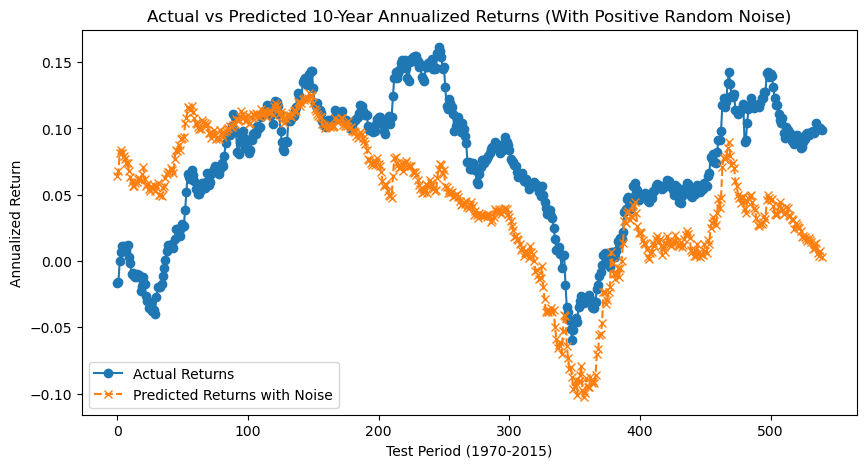

In [348]:
# Separate features (TR CAPE) and target (Real Return)
X_train_full = train_set_full[['TR CAPE']]
y_train_full = train_set_full['Real Return']

X_test = test_set[['TR CAPE']]
y_test = test_set['Real Return']

# Train the linear regression model
model_full = LinearRegression()
model_full.fit(X_train_full, y_train_full)

# Predict on the test set
y_pred_full = model_full.predict(X_test)

# Add positive random noise to predictions
np.random.seed(42)  # For reproducibility
noise = np.abs(np.random.normal(loc=0, scale=0.002, size=len(y_pred_full)))  # Small positive noise
y_pred_with_noise = y_pred_full + noise

# Calculate Mean Squared Error (MSE) for evaluation
mse_with_noise = mean_squared_error(y_test, y_pred_with_noise)

# Display results
print(f"TR CAPE Model with Positive Random Noise - MSE on Test Set: {mse_with_noise}")
print(f"Alpha (Intercept): {model_full.intercept_}")
print(f"Beta (Slope): {model_full.coef_[0]}")

# Plot Actual vs Predicted Returns with Noise
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Returns', marker='o')
plt.plot(y_pred_with_noise, label='Predicted Returns with Noise', marker='x', linestyle='--')
plt.title('Actual vs Predicted 10-Year Annualized Returns (With Positive Random Noise)')
plt.xlabel('Test Period (1970-2015)')
plt.ylabel('Annualized Return')
plt.legend()
plt.show()

## Improved Model

### Collect data for the var model

In [349]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

train_set = train_set_full
# Compute processed variables
train_set["Earnings_Yield"] = 1 / train_set["CAPE"]
test_set["Earnings_Yield"] = 1 / test_set["CAPE"]

train_set["Inflation"] = train_set["CPI"].pct_change(12)
test_set["Inflation"] = test_set["CPI"].pct_change(12)

train_set["Real_Bond_Yield"] = train_set["Rate GS10"] - train_set["Inflation"]
test_set["Real_Bond_Yield"] = test_set["Rate GS10"] - test_set["Inflation"]

train_set["Stock_Volatility"] = train_set["Returns.2"].rolling(window=12).std()
test_set["Stock_Volatility"] = test_set["Returns.2"].rolling(window=12).std()

train_set["Bond_Volatility"] = train_set["Real_Bond_Yield"].rolling(window=12).std()
test_set["Bond_Volatility"] = test_set["Real_Bond_Yield"].rolling(window=12).std()

# Select ONLY the 5 necessary columns for the VAR model
train_var_data = train_set[["Earnings_Yield", "Real_Bond_Yield", "Inflation", "Stock_Volatility", "Bond_Volatility"]].copy()
test_var_data = test_set[["Earnings_Yield", "Real_Bond_Yield", "Inflation", "Stock_Volatility", "Bond_Volatility"]].copy()

# Drop NaNs from rolling calculations
train_var_data.dropna(inplace=True)
test_var_data.dropna(inplace=True)

# Convert column to numeric, forcing errors to NaN
train_var_data["Real_Bond_Yield"] = pd.to_numeric(train_var_data["Real_Bond_Yield"], errors="coerce")
# Convert column to numeric, forcing errors to NaN
test_var_data["Real_Bond_Yield"] = pd.to_numeric(test_var_data["Real_Bond_Yield"], errors="coerce")

# Display prepared data
train_var_data.head()
test_var_data.head()

/var/folders/z2/3p1x7x716ls1xf7_rclbghrr0000gp/T/ipykernel_37127/2486151534.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set["Earnings_Yield"] = 1 / train_set["CAPE"]
/var/folders/z2/3p1x7x716ls1xf7_rclbghrr0000gp/T/ipykernel_37127/2486151534.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["Earnings_Yield"] = 1 / test_set["CAPE"]
/var/folders/z2/3p1x7x716ls1xf7_rclbghrr0000gp/T/ipykernel_37127/2486151534.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

,Earnings_Yield,Real_Bond_Yield,Inflation,Stock_Volatility,Bond_Volatility
1213,0.057260,6.044912,0.035088,0.006344,0.337566
1214,0.056162,6.035000,0.035000,0.008962,0.309162
1215,0.055819,6.155087,0.034913,0.010035,0.290512
1216,0.056617,6.097742,0.032258,0.010803,0.284438
1217,0.056687,6.082906,0.027094,0.011631,0.263648


In [350]:
print(train_var_data.dtypes)

Earnings_Yield      float64
Real_Bond_Yield     float64
Inflation           float64
Stock_Volatility    float64
Bond_Volatility     float64
dtype: object


### Train Var Model

In [351]:
# lag earning by 6 months
# lag cpi data by 2 months
# Simulate the real world scenario

In [352]:
# Fit VAR model on train data
var_model = VAR(train_var_data)
var_results = var_model.fit(12) 

print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 01, Mar, 2025
Time:                     16:02:25
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -47.4122
Nobs:                     1035.00    HQIC:                  -48.3160
Log likelihood:           18251.5    FPE:                5.98346e-22
AIC:                     -48.8686    Det(Omega_mle):     4.49367e-22
--------------------------------------------------------------------
Results for equation Earnings_Yield
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.000500         0.000616            0.811           0.417
L1.Earnings_Yield            1.261697         0.033272           37.921           0.000
L1.Real_Bond_Yield     

/Users/guoandrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [353]:
dividend_payout =  train_set_full['dividend_payout'].mean()
dividend_payout

0.6665190350883397

In [354]:
test_var_data.head()

,Earnings_Yield,Real_Bond_Yield,Inflation,Stock_Volatility,Bond_Volatility
1213,0.057260,6.044912,0.035088,0.006344,0.337566
1214,0.056162,6.035000,0.035000,0.008962,0.309162
1215,0.055819,6.155087,0.034913,0.010035,0.290512
1216,0.056617,6.097742,0.032258,0.010803,0.284438
1217,0.056687,6.082906,0.027094,0.011631,0.263648


In [355]:
# Prepare storage for earnings yield predictions
earnings_yield_predictions = []

test_values = test_var_data.values

for i in range(len(test_var_data) - 12): 
    # Select the past 12 months of data as input for VAR
    forecast_input = test_values[i : i + 12]
    
    # Forecast next 10 steps
    forecast = var_results.forecast(forecast_input, steps=1)
    
    predicted_earnings_yield = forecast.mean(axis=0)[0]

    earnings_yield_predictions.append({
        "Date": test_var_data.index[i + 12],  # Store prediction for t+1
        "Predicted_Earnings_Yield": predicted_earnings_yield
    })

# Convert to DataFrame
earnings_yield_df = pd.DataFrame(earnings_yield_predictions)

# Merge predicted earnings yield back into test data
test_var_data = test_var_data.iloc[12:].copy() 
test_var_data["Predicted_Earnings_Yield"] = earnings_yield_df["Predicted_Earnings_Yield"].values

test_var_data.head(10)

,Earnings_Yield,Real_Bond_Yield,Inflation,Stock_Volatility,Bond_Volatility,Predicted_Earnings_Yield
1225,0.055897,6.601259,0.038741,0.004447,0.192212,0.055219
1226,0.057431,6.664106,0.045894,0.004497,0.208627,0.058767
1227,0.059047,6.619398,0.050602,0.004961,0.218443,0.056736
1228,0.061296,6.794712,0.055288,0.006309,0.235272,0.060217
1229,0.063258,6.840048,0.059952,0.008495,0.239596,0.062211
1230,0.062935,7.072721,0.057279,0.010084,0.260230,0.066044
1231,0.065451,7.326190,0.073810,0.010529,0.312879,0.064615
1232,0.064619,7.016366,0.073634,0.011202,0.325680,0.066254
1233,0.062840,6.711986,0.078014,0.011215,0.315872,0.066520
1234,0.068251,6.647453,0.082547,0.011328,0.279934,0.065617


In [356]:
# Prepare storage for full test set return predictions
predictions = []

# Loop over the entire test dataset using predicted earnings yield
for i in range(len(test_var_data) - 1):  
    earnings_yield_t = test_var_data.iloc[i]["Earnings_Yield"]
    earnings_yield_t1 = test_var_data.iloc[i + 1]["Predicted_Earnings_Yield"]

    PE_t = 1 / earnings_yield_t
    PE_t1 = 1 / earnings_yield_t1
    pct_change_PE = (PE_t1 - PE_t) / PE_t

    # Use constant earnings growth rate (historical average from train set)
    pct_change_E = train_var_data["Earnings_Yield"].pct_change(12).mean()

    # Compute Dividend Yield using actual dividend payout ratio from test data
    DP_t1 = earnings_yield_t1 * dividend_payout

    # Compute expected return using the formula
    expected_return = pct_change_PE + pct_change_E + DP_t1

    # Store result
    predictions.append({
        "Date": test_var_data.index[i + 1], 
        "Predicted_Return": expected_return
    })

predictions_df = pd.DataFrame(predictions)
predictions_df['Predicted_Return'].mean()

0.08579676329921634

In [357]:
len(y_pred_with_noise)

540

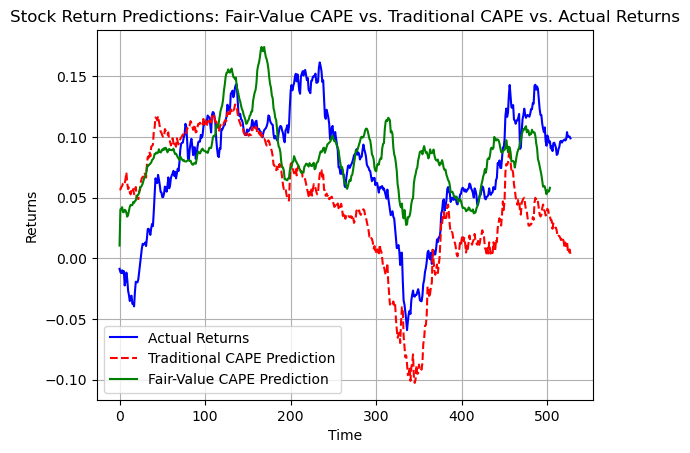

In [367]:
import matplotlib.pyplot as plt

# Plot actual returns
plt.plot(y_test.values[12:], label="Actual Returns", color='blue')

# Plot traditional CAPE model predictions
plt.plot(y_pred_with_noise[12:], label="Traditional CAPE Prediction", linestyle='--', color='red')

# Plot Fair-Value CAPE predictions
plt.plot(predictions_df['Predicted_Return'].rolling(window=24, min_periods=1).mean(), label="Fair-Value CAPE Prediction", color='green')

# Formatting the plot
plt.legend()
plt.title("Stock Return Predictions: Fair-Value CAPE vs. Traditional CAPE vs. Actual Returns")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.grid(True)

# Show the plot
plt.show()